## EUKulele tuneR
SKH - Oct 2020

In [1]:
## to be moved to EUKulele execution tutorial ##

Tutorial below details EUKulele usage with protistan metatranscriptome data, explores EUKulele database options, and how to compile output files in R for downstream data analysis.

### Example install & execution of EUKulele
Set up EUKulele in its own conda environment

```
conda create --name EUKulele

# Activate the environment
conda activate EUKulele

# Install dependencies for EUKulele
conda install blast busco=4.0.6 diamond transdecoder ujson pandas yaml chardet pyyaml numpy joblib
pip install python-coveralls matplotlib pytest-cov argparse scipy zenodo-get biopython==1.77

# Install EUKulele (v0.0.27)
conda install -c akrinos eukulele
```

### Navigating EUKulele
Since EUKulele will determine taxonomic assignment for provided sequence data, you can retrieve those databases ahead of time if needed (or create your own). By default EUKulele will download and use MMETSP. Options for databases include: MMETSP (```mmetsp```), PhyloDB (```phylodb```), Eukprot (```eukprot```), or EukZoo (```eukzoo```). To only download the database, run the following command:

```
# Within the EUKulele conda environment
EUKulele download --reference_dir phylodb
```

In [1]:
## Include database composition here??
## See below section (1) EUKulele provided databases

In [2]:
# EUKulele -m mets 
#     -s /vortexfs1/omics/alexander/data/NB_subsampled_11Sept/inputfiles/megamerge/ 
#     --alignment_choice diamond 
#     --reference_dir /vortexfs1/omics/alexander/shu/db/mmetsp/ 
#     -o tmp-07-10 
#     --n_ext .fasta


### Input data structure
These data were assembled using megahit, which generates a directory for each assembly with contigs in a file called ```final.contigs.fa```. To run EUKulele and downstream steps most appropriately, I needed these non-descript file names to have actual sample names. And merge them together.

_Cite original data from NB_ Additional information on how these were merged and CD-HIT

In [2]:
#
# Above text will end up in Tutorial for running EUKulele, below will end up in the EUKulele compilation with R
#

In [2]:
library(tidyverse); library(cowplot); library(ggalluvial)

── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.3     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.4.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


### Import estimated-taxonomy outputs from EUKulele

Input requires files from ```/taxonomic_estimation``` directory

In [3]:
# Import EUKulele output from running NB database with MMETSP
mmetsp_dia_nb <- read.delim("/vortexfs1/omics/alexander/shu/eukulele-test/mmetsp-diamond/nb-output-03-10/taxonomy_estimation/merged_merged-estimated-taxonomy.out")
head(mmetsp_dia_nb)

X,transcript_name,classification_level,full_classification,classification,max_pid,ambiguous
0,megahit_NarBay_A_megahit_NarBay_A_k111_0,species,Stramenopiles; Ochrophyta; Bacillariophyta; Bacillariophyta_X; Polar-centric-Mediophyceae; Skeletonema; Skeletonema grethea,Skeletonema grethea,100.0,0
0,megahit_NarBay_A_megahit_NarBay_A_k111_10,species,Hacrobia; Haptophyta; Prymnesiophyceae; Prymnesiales; Chrysochromulinaceae; Chrysochromulina; Chrysochromulina ericina,Chrysochromulina ericina,95.5,0
0,megahit_NarBay_A_megahit_NarBay_A_k111_100,species,Hacrobia; Haptophyta; Prymnesiophyceae; Prymnesiales; Chrysochromulinaceae; Chrysochromulina; Chrysochromulina ericina,Chrysochromulina ericina,100.0,0
0,megahit_NarBay_A_megahit_NarBay_A_k111_1005,species,Alveolata; Dinoflagellata; Dinophyceae; Prorocentrales; Prorocentraceae; Prorocentrum; Prorocentrum minimum,Prorocentrum minimum,100.0,0
0,megahit_NarBay_A_megahit_NarBay_A_k111_1008,family,Stramenopiles; Ochrophyta; Bacillariophyta; Bacillariophyta_X; Araphid-pennate,Araphid-pennate,77.1,0
0,megahit_NarBay_A_megahit_NarBay_A_k111_101,order,Stramenopiles; Ochrophyta; Dictyochophyceae; Dictyochophyceae_X,Dictyochophyceae_X,52.8,0


In [4]:
dim(mmetsp_dia_nb)

[1] 6110375       7

### R functions for MMETSP

In [17]:
# For each Sample, what number of contigs had ambiguous matches?
# How many contigs were assigned to various classification levels?
eukulele_stats_mmetsp <- function(df_tax_est){
    df_tax_est %>% 
        group_by(Sample) %>% 
        summarise(Total_contigs = n_distinct(transcript_name),
                  Num_ambig = sum(ambiguous == 1),
                SUPERGROUP = sum(str_count(classification_level, "supergroup")),
                 CLASS = sum(str_count(classification_level, "class")),
                 FAMILY = sum(str_count(classification_level, "family")),
                 ORDER = sum(str_count(classification_level, "order")),
                 GENUS = sum(str_count(classification_level, "genus")),
                 SPECIES = sum(str_count(classification_level, "species")),
                 Distinct_tax_ids = n_distinct(full_classification)) %>% 
        data.frame
    }

In [30]:
eukulele_stats_mmetsp(mmetsp_blast_nb)
eukulele_stats_mmetsp(mmetsp_dia_nb)

`summarise()` ungrouping output (override with `.groups` argument)



Sample,Total_contigs,Num_ambig,SUPERGROUP,CLASS,FAMILY,ORDER,GENUS,SPECIES,Distinct_tax_ids
<fct>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
SRR1810204_merged,210,214,0,12,24,12,214,148,29
SRR1810205_merged,255,30,0,12,54,36,115,32,75
SRR1810206_merged,304,28,0,22,77,38,121,39,67
SRR1810207_merged,170,16,0,13,36,32,61,25,51
SRR1810208_merged,87,6,0,3,27,15,26,15,39
SRR1810209_merged,144,15,1,9,27,22,49,29,58
SRR1810210_merged,359,32,0,28,94,82,116,35,65
SRR1810211_merged,132,23,0,6,26,25,42,24,53
SRR1810799_merged,223,122,0,2,25,15,134,42,62


`summarise()` ungrouping output (override with `.groups` argument)



Sample,Total_contigs,Num_ambig,SUPERGROUP,CLASS,FAMILY,ORDER,GENUS,SPECIES,Distinct_tax_ids
<fct>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
SRR1810204_merged,203,196,0,12,16,14,204,148,23
SRR1810205_merged,249,38,0,12,66,41,102,21,59
SRR1810206_merged,298,38,0,20,84,47,111,30,56
SRR1810207_merged,167,13,0,15,38,31,56,23,46
SRR1810208_merged,85,11,0,6,20,23,24,12,36
SRR1810209_merged,142,18,1,8,34,28,40,24,50
SRR1810210_merged,341,36,0,27,95,80,106,27,52
SRR1810211_merged,129,24,0,7,31,25,36,19,47
SRR1810799_merged,220,117,0,3,23,16,127,49,60


In [32]:
# For each sample, how many contigs were assigned to various classification levels?
plot_classification <- function(df_tax_est){
    plot_grid(
        df_tax_est  %>% 
        replace_na(list(counts = 1)) %>% 
        add_column(counts = 1) %>% 
        group_by(Sample, classification_level) %>% 
        summarise(SUM_classification_level = sum(counts)) %>% 
    ggplot(aes(x = Sample, y = SUM_classification_level, fill = classification_level)) +
        geom_bar(stat = "identity", color = "black") +
        coord_flip() +
        theme_minimal() +
        theme(legend.position = "bottom", legend.title = element_blank()),
    ggplot(df_tax_est, aes(x = Sample, y = max_pid, fill = classification_level)) +
        geom_jitter(shape = 21, color = "black") +
        geom_boxplot() +
        coord_flip() +
        theme_minimal() +
        theme(legend.position = "bottom", legend.title = element_blank()),
    ncol = 2)       
}

`summarise()` regrouping output by 'Sample' (override with `.groups` argument)



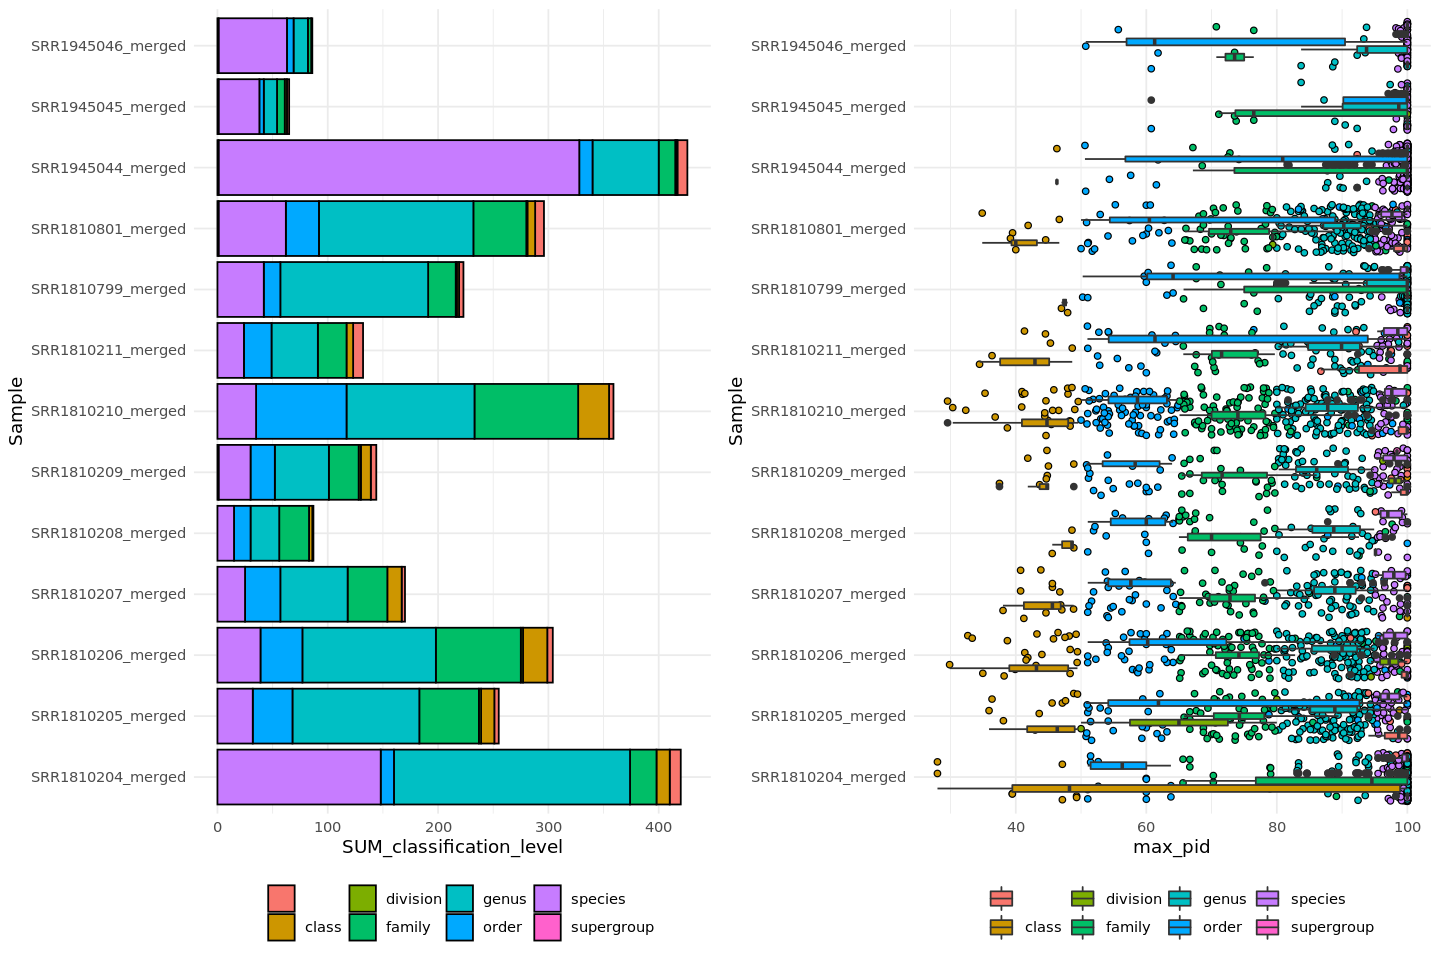

In [33]:
options(repr.plot.width = 12, repr.plot.height = 8) # Set plot output space
plot_classification(mmetsp_blast_nb)

`summarise()` regrouping output by 'Sample' (override with `.groups` argument)



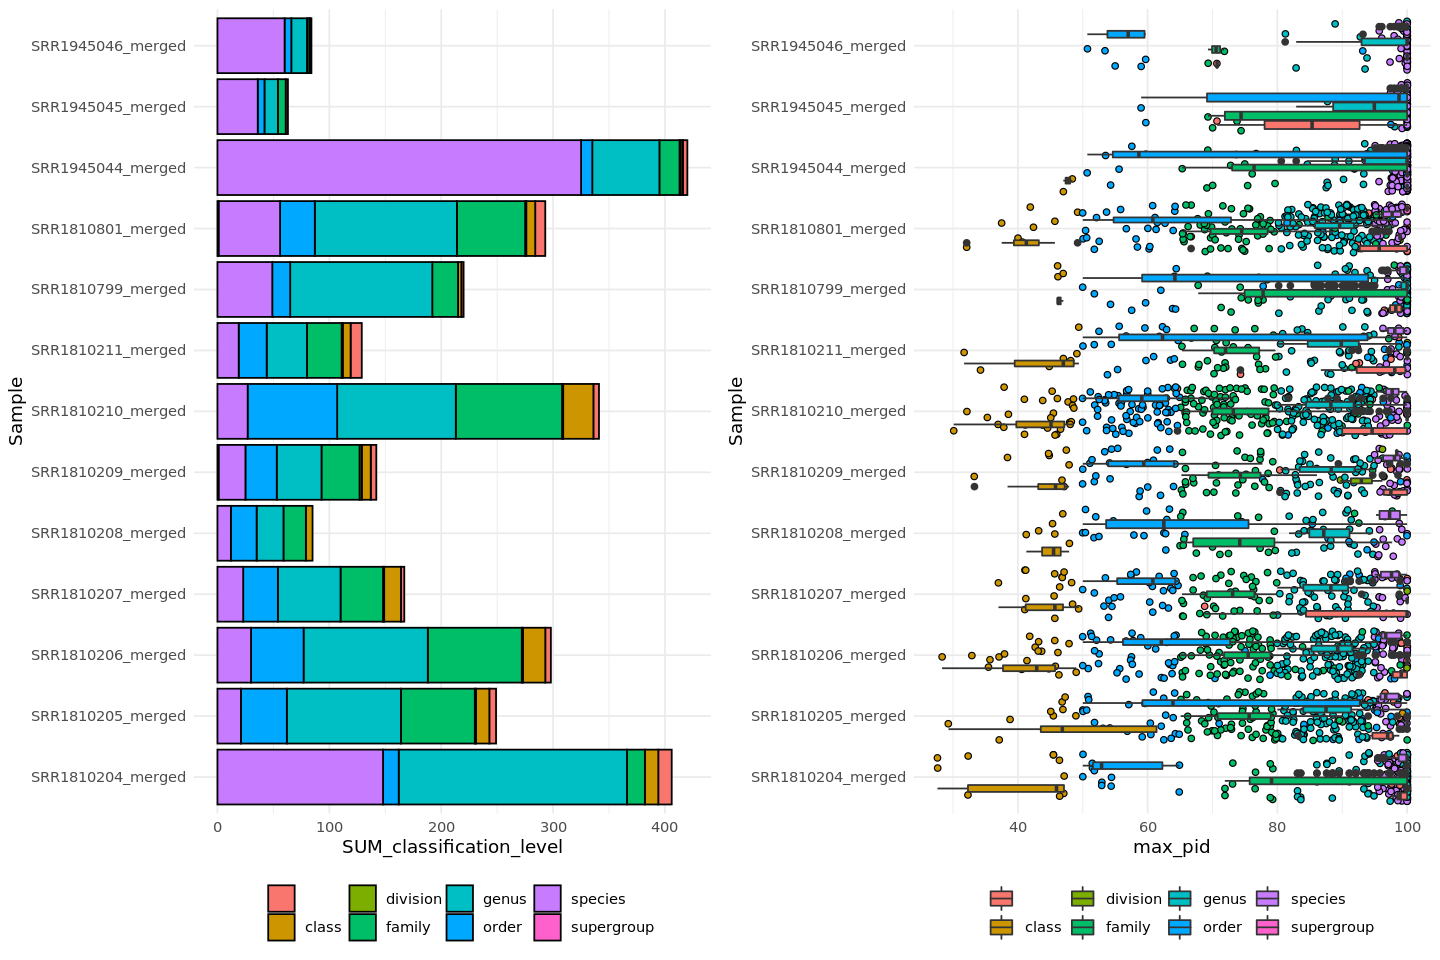

In [34]:
options(repr.plot.width = 12, repr.plot.height = 8) # Set plot output space
plot_classification(mmetsp_dia_nb)

In [40]:
# Create a dataframe with parsed classification
parse_mmetsp <- function(df_est) {
    df_out <- df_est %>% 
        separate(full_classification, 
                 c("supergroup", "class", "family", "order", "genus", "species"), 
                 sep = ";", remove = FALSE) %>% 
        add_column(COUNT = 1) %>% 
        data.frame
    return(df_out)
    }

In [41]:
dia_parsed <- parse_mmetsp(mmetsp_dia_nb)
blas_parsed <- parse_mmetsp(mmetsp_blast_nb)

Warning message:
“Expected 6 pieces. Additional pieces discarded in 829 rows [1, 3, 6, 10, 12, 18, 19, 24, 27, 31, 34, 35, 38, 40, 41, 48, 49, 50, 52, 53, ...].”
Warning message:
“Expected 6 pieces. Missing pieces filled with `NA` in 1049 rows [4, 5, 14, 15, 17, 22, 23, 25, 30, 61, 71, 76, 86, 100, 102, 108, 117, 123, 140, 141, ...].”
Warning message:
“Expected 6 pieces. Additional pieces discarded in 876 rows [1, 3, 6, 10, 12, 18, 19, 24, 27, 31, 34, 35, 38, 40, 41, 42, 49, 50, 51, 53, ...].”
Warning message:
“Expected 6 pieces. Missing pieces filled with `NA` in 988 rows [4, 14, 17, 22, 23, 30, 33, 52, 62, 69, 72, 77, 87, 104, 110, 114, 120, 126, 130, 144, ...].”


In [62]:
head(blas_parsed)
colnames(blas_parsed)

,X,transcript_name,classification_level,full_classification,supergroup,class,family,order,genus,species,classification,max_pid,ambiguous,Sample,COUNT
,<int>,<fct>,<fct>,<fct>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<fct>,<dbl>,<int>,<fct>,<dbl>
1,0,megahit_SRR1810204_k71_10,species,Stramenopiles; Ochrophyta; Bacillariophyta; Bacillariophyta_X; Polar-centric-Mediophyceae; Skeletonema; Skeletonema marinoi,Stramenopiles,Ochrophyta,Bacillariophyta,Bacillariophyta_X,Polar-centric-Mediophyceae,Skeletonema,Skeletonema marinoi,100.00,0,SRR1810204_merged,1
2,0,megahit_SRR1810204_k71_100,genus,Stramenopiles; Ochrophyta; Bacillariophyta; Bacillariophyta_X; Polar-centric-Mediophyceae; Skeletonema,Stramenopiles,Ochrophyta,Bacillariophyta,Bacillariophyta_X,Polar-centric-Mediophyceae,Skeletonema,Skeletonema,100.00,1,SRR1810204_merged,1
3,0,megahit_SRR1810204_k71_101,species,Stramenopiles; Ochrophyta; Bacillariophyta; Bacillariophyta_X; Polar-centric-Mediophyceae; Skeletonema; Skeletonema marinoi,Stramenopiles,Ochrophyta,Bacillariophyta,Bacillariophyta_X,Polar-centric-Mediophyceae,Skeletonema,Skeletonema marinoi,100.00,0,SRR1810204_merged,1
4,0,megahit_SRR1810204_k71_102,class,Stramenopiles; Ochrophyta; Bacillariophyta,Stramenopiles,Ochrophyta,Bacillariophyta,NA,NA,NA,Bacillariophyta,28.00,0,SRR1810204_merged,1
5,0,megahit_SRR1810204_k71_103,genus,Alveolata; Dinoflagellata; Dinophyceae; Peridiniales; Kryptoperidiniaceae; Durinskia,Alveolata,Dinoflagellata,Dinophyceae,Peridiniales,Kryptoperidiniaceae,Durinskia,Durinskia,89.29,0,SRR1810204_merged,1
6,0,megahit_SRR1810204_k71_104,species,Stramenopiles; Ochrophyta; Bacillariophyta; Bacillariophyta_X; Raphid-pennate; Nitzschia; Nitzschia sp.,Stramenopiles,Ochrophyta,Bacillariophyta,Bacillariophyta_X,Raphid-pennate,Nitzschia,Nitzschia sp.,100.00,0,SRR1810204_merged,1


[1] "X"                    "transcript_name"      "classification_level"
 [4] "full_classification"  "supergroup"           "class"               
 [7] "family"               "order"                "genus"               
[10] "species"              "classification"       "max_pid"             
[13] "ambiguous"            "Sample"               "COUNT"

In [ ]:
# Incorporate salmon counts and other data if applicable

# COUNT = 1 in this case because no salmon files were incorporated...

In [79]:
# Function to plot at chosen taxonomic level
plot_mmetsp_atlevel <- function(df_in, level){
    LEVEL <- enquo(level)
    out <- df_in %>% 
        type.convert(as.is = TRUE) %>%
        group_by(!!LEVEL, Sample) %>% 
        summarise(SUM = sum(COUNT)) %>% 
        data.frame
    ggplot(out, aes(x = Sample, fill = !!LEVEL, y = SUM)) +
        geom_bar(stat = "identity", color = "black") +
        coord_flip() +
        theme_minimal()
}

`summarise()` regrouping output by 'class' (override with `.groups` argument)

`summarise()` regrouping output by 'supergroup' (override with `.groups` argument)



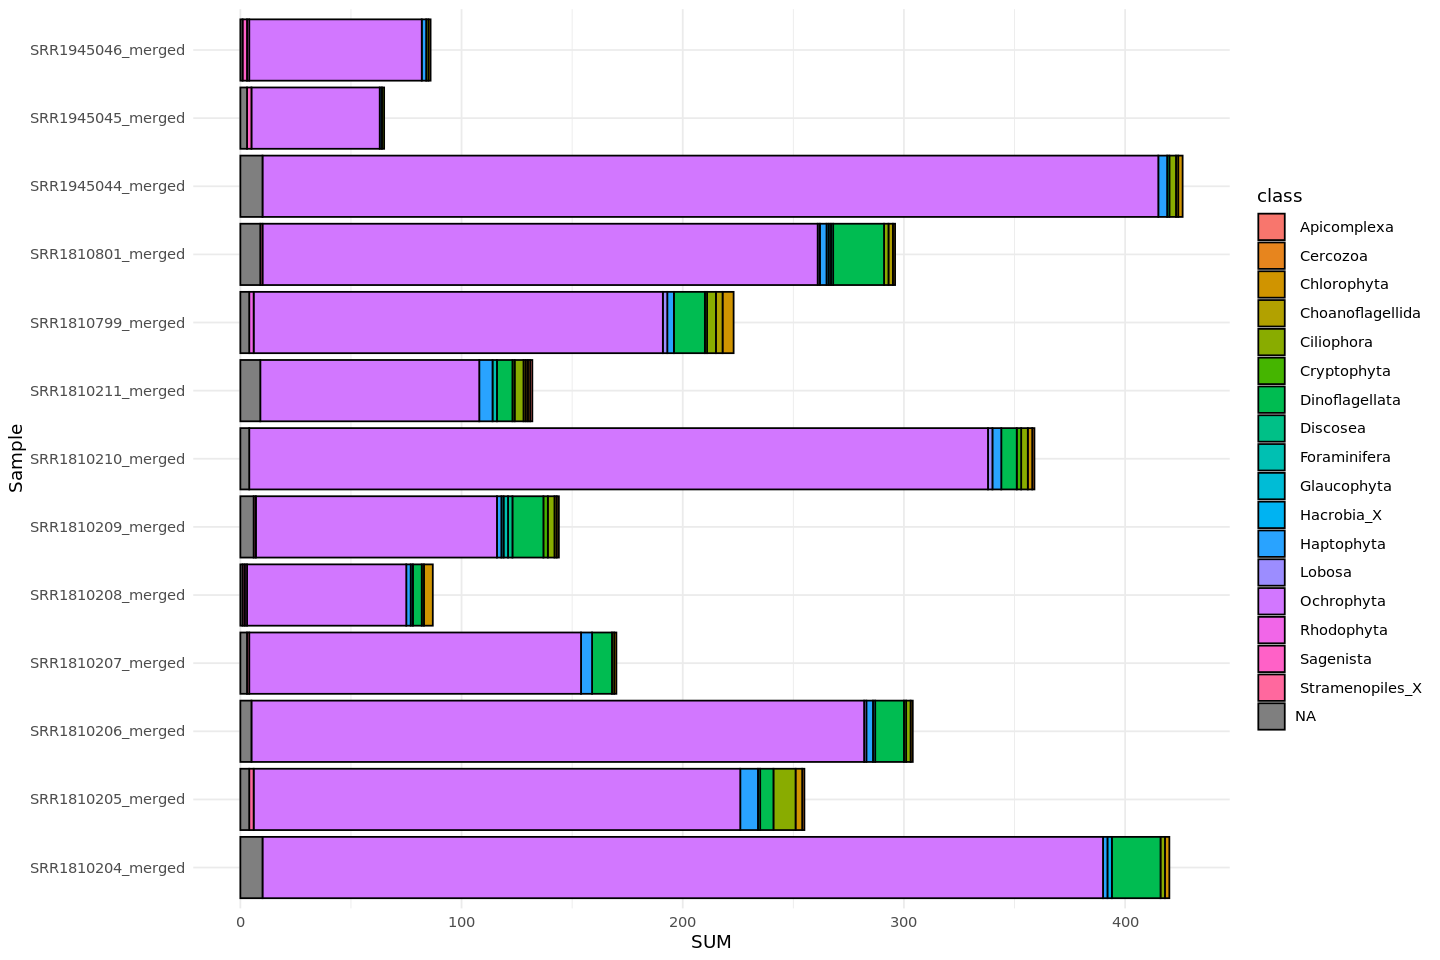

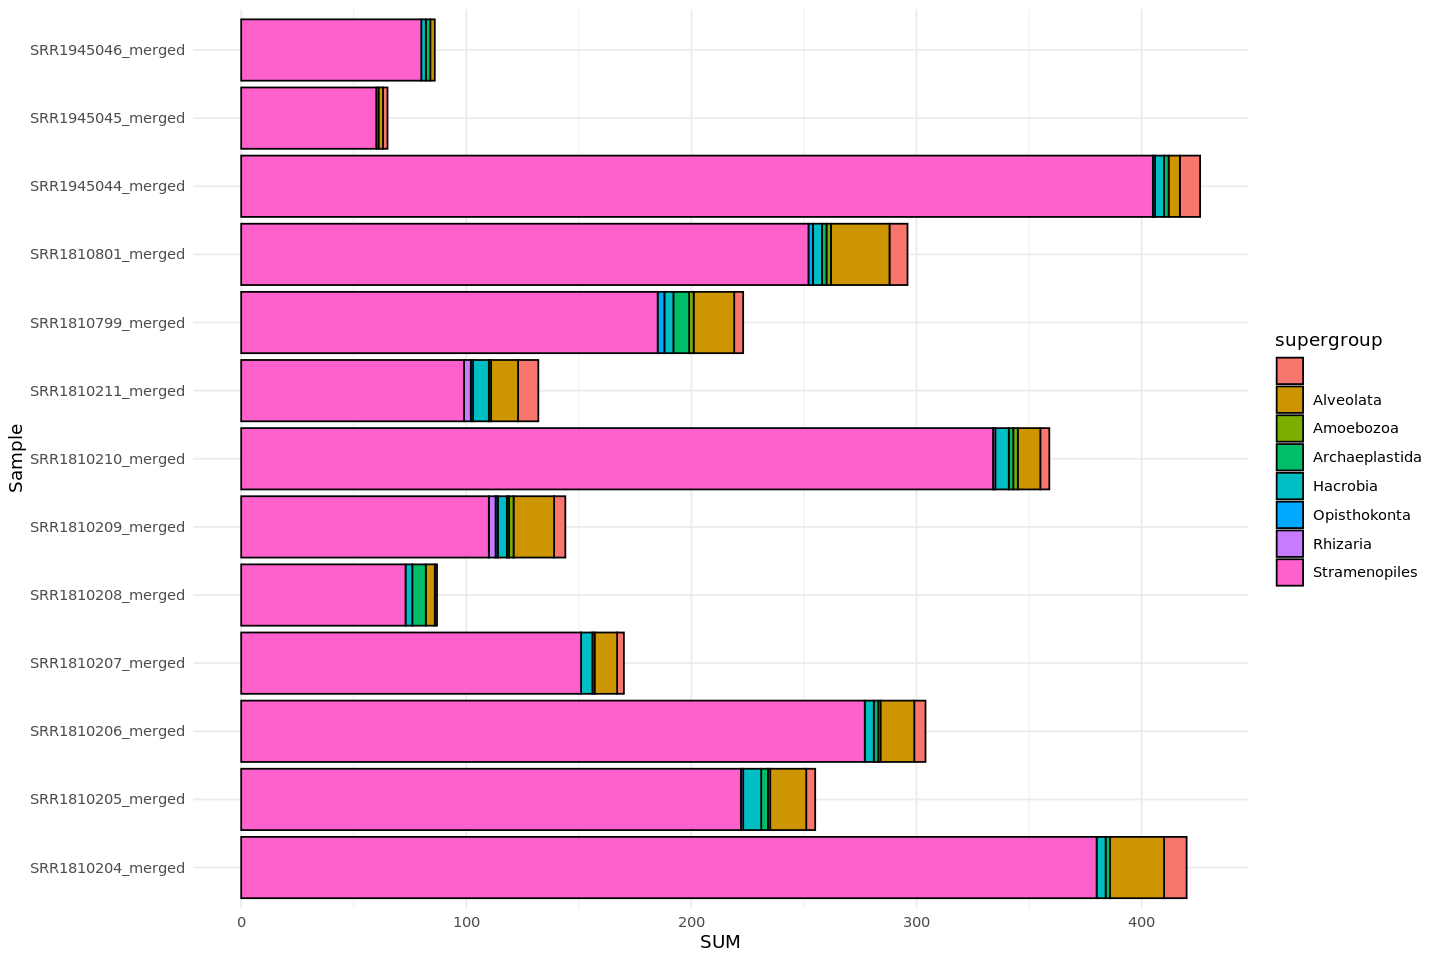

In [81]:
plot_mmetsp_atlevel(blas_parsed, class)
plot_mmetsp_atlevel(blas_parsed, supergroup)

In [3]:
# Incorporate busco outputs

In [4]:
# additional MMETSP output

### R functions for phylodb

In [5]:
# For each Sample, what number of contigs had ambiguous matches?
# How many contigs were assigned to various classification levels?
eukulele_stats_phylodb <- function(df_tax_est){
    df_tax_est %>% 
        group_by(Sample) %>% 
        summarise(Total_contigs = n_distinct(transcript_name),
                  Num_ambig = sum(ambiguous == 1),
                SUPERGROUP = sum(str_count(classification_level, "supergroup")),
                 CLASS = sum(str_count(classification_level, "class")),
                 FAMILY = sum(str_count(classification_level, "family")),
                 ORDER = sum(str_count(classification_level, "order")),
                 GENUS = sum(str_count(classification_level, "genus")),
                 SPECIES = sum(str_count(classification_level, "species")),
                 Distinct_tax_ids = n_distinct(full_classification)) %>% 
        data.frame
    }

### R functions for eukprot

In [22]:
head(mmetsp[1:2,])
head(phylodb[1:2,])
head(eukprot[1:2,])

,X,CYVERSE_PATH,Source_ID_dup,REF_STATUS,Source_ID,Strain,Supergroup,Division,Class,Order,Family,Genus,Species,Notes
,<int>,<dbl>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>
1,0,2225,MMETSP0290,Clean,MMETSP0290,CCMP2878,Alveolata,Apicomplexa,Colpodellidea,Colpodellida,Chromeraceae,Chromera,Chromera velia,Curated by J. del Campo (PR2)
2,1,2224,MMETSP0288,Clean,MMETSP0288,CCMP3155,Alveolata,Apicomplexa,Colpodellidea,Vitrelladida,Vitrellaceae,Vitrella,Vitrella brassicaformis,Adl et al. 2019; Curated by J. del Campo and Vaulot D. (PR2)


,strain_name,peptide_count,taxonomy
,<fct>,<int>,<fct>
1,Acidilobus saccharovorans 345-15,1499,Archaea;Crenarchaeota;Thermoprotei;Acidilobales;Acidilobaceae;Acidilobus;Acidilobus saccharovorans 345-15
2,Caldisphaera lagunensis DSM 15908,1527,Archaea;Crenarchaeota;Thermoprotei;Acidilobales;Caldisphaeraceae;Caldisphaera;Caldisphaera lagunensis DSM 15908


,X,EukProt_ID,Name_to_Use,Strain,Previous_Names,Replaces_EukProt_ID,Genus_UniEuk,Epithet_UniEuk,Supergroup_UniEuk,Taxogroup_UniEuk,Taxonomy_UniEuk,Merged_Strains,Data_Source_URL,Data_Source_Name,Paper_DOI,Actions_Prior_to_Use,Data_Source_Type,Notes
,<int>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>
1,0,EP00001,Collodictyon_triciliatum,Arungen,,,Collodictyon,triciliatum,Collodictyonidae,Collodictyonidae,"Eukaryota;""CRuMs"";Collodictyonidae;Collodictyon;""Collo 18S-clade 1"";strain Arungen",no,,454AllContigs_Korea_transeq,10.1093/molbev/mss001,transeq (min length 50),transcriptome,
2,1,EP00002,Diphylleia_rotans,NIES-3764,,,Diphylleia,rotans,Collodictyonidae,Collodictyonidae,"Eukaryota;""CRuMs"";Collodictyonidae;Diphylleia;Diphylleia rotans;strain NIES-3764",no,https://trace.ncbi.nlm.nih.gov/Traces/sra/?run=SRR5997434,Diphylleia rotans NIES-3764 transcriptome,10.1093/gbe/evy014,"assemble mRNA,translate mRNA",transcriptome,


In [37]:
mmetsp_tax <- compile_estimated_tax("mmetsp-diamond", mmetsp_path)
phylodb_tax <- compile_estimated_tax("phylodb-diamond", phylodb_path)

Found Site113-2013-1000-estimated-taxonomy.out
Found Site113-2014-1000-estimated-taxonomy.out
Found Site113-2015-1000-estimated-taxonomy.out
Found Site33-2013-1000-estimated-taxonomy.out
Found Site33-2014-1000-estimated-taxonomy.out
Found Site33-2015-1000-estimated-taxonomy.out
Imported Site113-2013-1000 added 335 identities.
Imported Site113-2013-1000 added 335 identities.
Imported Site113-2014-1000 added 314 identities.
Imported Site113-2015-1000 added 332 identities.
Imported Site33-2013-1000 added 372 identities.
Imported Site33-2014-1000 added 374 identities.
Imported Site33-2015-1000 added 336 identities.
Found 


ERROR: Error in compile_estimated_tax("phylodb-diamond", phylodb_path): object 'compiled_est_tax' not found


In [38]:
head(phylodb_tax[1:2,])

,X,transcript_name,classification_level,full_classification,classification,max_pid,ambiguous,counts,Sample,DB
,<int>,<fct>,<fct>,<fct>,<fct>,<dbl>,<int>,<lgl>,<chr>,<chr>
1,0,k119_1018,genus,Bacteria; Proteobacteria; Deltaproteobacteria; Misc. Deltaproteobacteria; Environmental Deltaproteobacteria; Uncultured Deltaproteobacteria,Uncultured Deltaproteobacteria,87.3,0,NA,Site113-2013-100,phylodb-diamond
2,0,k119_1060,genus,Bacteria; Proteobacteria; Epsilonproteobacteria; Campylobacterales; Campylobacteraceae; Campylobacteraceae_X,Campylobacteraceae_X,80.5,0,NA,Site113-2013-100,phylodb-diamond


In [68]:
head(mmetsp_tax[1:2,])

,X,transcript_name,classification_level,full_classification,classification,max_pid,ambiguous,Sample,DB
,<int>,<fct>,<fct>,<fct>,<fct>,<dbl>,<int>,<chr>,<chr>
1,0,k119_1018,order,Alveolata; Dinoflagellata; Dinophyceae; Peridiniales,Peridiniales,60.8,0,Site113-2013-1000,mmetsp-diamond
2,0,k119_1075,class,Stramenopiles; Ochrophyta; Bacillariophyta; Bacillariophyta_X,Bacillariophyta_X,46.8,0,Site113-2013-1000,mmetsp-diamond


In [6]:
# Join all together based on "transcript_name" - use fuzzy join to classify the # of different letters...

In [41]:
library(fuzzyjoin)

all_equal(phylodb_tax, phylodb_tax)

In [96]:
all_equal(phylodb_tax, mmetsp_tax)

- different number of columns: 10 vs 9

In [100]:
fruit <- c("apple", "banana", "pear", "pineapple")
(str_detect(fruit, "a"))

[1] TRUE TRUE TRUE TRUE

In [103]:
sum(str_detect(fruit, "b"))
str_detect(fruit, "b")

[1] 1

[1] FALSE  TRUE FALSE FALSE

In [104]:
str_detect(phylodb_tax$full_classification, phylodb_tax$full_classification)

ERROR: Error in UseMethod("type"): no applicable method for 'type' applied to an object of class "factor"


In [4]:
dats<-data.frame(ID=c(1:3),species=c("dog","cat","rabbit"),species.descriptor=c("all animal dog","all animal cat","rabbit exotic"),product=c(1,2,3), product.authorise=c("all animal dog cat rabbit","cat horse pig","dog cat"))
str(dats)

'data.frame':	3 obs. of  5 variables:
 $ ID                : int  1 2 3
 $ species           : Factor w/ 3 levels "cat","dog","rabbit": 2 1 3
 $ species.descriptor: Factor w/ 3 levels "all animal cat",..: 2 1 3
 $ product           : num  1 2 3
 $ product.authorise : Factor w/ 3 levels "all animal dog cat rabbit",..: 1 2 3


In [5]:
goal<-data.frame(ID=c(1:3),species=c("dog","cat","rabbit"),
            species.descriptor=c("all animal dog","all animal cat","rabbit exotic"),
            product=c(1,2,3),product.authorise=c("all animal dog cat rabbit","cat horse pig",
            "dog cat"), authorised=c("TRUE","TRUE","FALSE"))   
goal

ID,species,species.descriptor,product,product.authorise,authorised
<int>,<fct>,<fct>,<dbl>,<fct>,<fct>
1,dog,all animal dog,1,all animal dog cat rabbit,TRUE
2,cat,all animal cat,2,cat horse pig,TRUE
3,rabbit,rabbit exotic,3,dog cat,FALSE


In [6]:
dats$species <- as.character(dats$species)
dats$species.descriptor <- as.character(dats$species.descriptor)
dats$product.authorise <- as.character(dats$product.authorise)

dats %>%
mutate(authorised = 
           str_detect(species.descriptor, species) & 
           str_detect(product.authorise, species)
       )

ID,species,species.descriptor,product,product.authorise,authorised
<int>,<chr>,<chr>,<dbl>,<chr>,<lgl>
1,dog,all animal dog,1,all animal dog cat rabbit,TRUE
2,cat,all animal cat,2,cat horse pig,TRUE
3,rabbit,rabbit exotic,3,dog cat,FALSE


In [134]:
str(mmetsp_tax)
mmetsp_tax$Sample<-gsub("-1000", "-100", mmetsp_tax$Sample)

'data.frame':	2398 obs. of  9 variables:
 $ X                   : int  0 0 0 0 0 0 0 0 0 0 ...
 $ transcript_name     : Factor w/ 1843 levels "k119_1018","k119_1075",..: 1 2 3 4 5 6 7 8 9 10 ...
 $ classification_level: Factor w/ 8 levels "","class","division",..: 6 2 2 2 1 2 2 4 6 4 ...
 $ full_classification : Factor w/ 203 levels "","Alveolata; Apicomplexa; Colpodellidea",..: 14 77 76 76 1 92 72 94 87 79 ...
 $ classification      : Factor w/ 200 levels "","Acanthoecida",..: 70 7 6 6 1 84 92 86 34 74 ...
 $ max_pid             : num  60.8 46.8 34.1 34.1 47.2 28.3 39.8 65.9 50.9 74.4 ...
 $ ambiguous           : int  0 0 0 0 1 0 0 0 0 0 ...
 $ Sample              : chr  "Site113-2013-1000" "Site113-2013-1000" "Site113-2013-1000" "Site113-2013-1000" ...
 $ DB                  : chr  "mmetsp-diamond" "mmetsp-diamond" "mmetsp-diamond" "mmetsp-diamond" ...


In [138]:
# str_detect(phylodb_tax$full_classification, phylodb_tax$full_classification)
tmp <- phylodb_tax %>% 
    left_join(mmetsp_tax, by = c("Sample" = "Sample", "transcript_name" = "transcript_name"), 
             suffix = c(".phylodb", ".mmetsp")) %>% 
    filter(!is.na(X.mmetsp)) %>% 
    mutate(across(where(is.factor), as.character)) %>% 
    mutate(count_compare = sum(str_detect(full_classification.phylodb, full_classification.mmetsp)))


Warning message:
“Problem with `mutate()` input `count_compare`.
✖ empty search patterns are not supported
ℹ Input `count_compare` is `sum(str_detect(full_classification.phylodb, full_classification.mmetsp))`.”
Warning message in stri_detect_regex(string, pattern, negate = negate, opts_regex = opts(pattern)):
“empty search patterns are not supported”


In [149]:
a <- as.character(mmetsp_tax$full_classification)[100];a
b <- as.character(phylodb_tax$full_classification)[100];b

[1] "Hacrobia; Cryptophyta; Cryptophyceae; Cryptomonadales"

[1] "Archaea; Euryarchaeota; Methanococci"

In [147]:
mapply(function(x,y) sum(x!=y),strsplit(a,""),strsplit(b,""))

Warning message in x != y:
“longer object length is not a multiple of shorter object length”


[1] 130

In [135]:
unique(phylodb_tax$Sample)
unique(mmetsp_tax$Sample)

[1] "Site113-2013-100" "Site113-2014-100" "Site113-2015-100" "Site33-2013-100" 
[5] "Site33-2014-100"  "Site33-2015-100"

[1] "Site113-2013-100" "Site113-2014-100" "Site113-2015-100" "Site33-2013-100" 
[5] "Site33-2014-100"  "Site33-2015-100"

In [155]:
# head(phylodb_tax)
phylodb_tax %>% filter(full_classification == "Eukaryota; Stramenopiles; Stramenopiles_X")

X,transcript_name,classification_level,full_classification,classification,max_pid,ambiguous,counts,Sample,DB
<int>,<fct>,<fct>,<fct>,<fct>,<dbl>,<int>,<lgl>,<chr>,<chr>
0,k119_178,class,Eukaryota; Stramenopiles; Stramenopiles_X,Stramenopiles_X,45.2,0,NA,Site33-2015-100,phylodb-diamond
0,k119_268,class,Eukaryota; Stramenopiles; Stramenopiles_X,Stramenopiles_X,38.3,0,NA,Site33-2015-100,phylodb-diamond


In [162]:
tmpa <- mmetsp_tax %>% filter(transcript_name == "k119_178")
tmpb <- phylodb_tax %>% filter(transcript_name == "k119_178")
a <- as.character(tmpa$full_classification)[1];a
b <- as.character(tmpb$full_classification)[1];b

[1] "Stramenopiles; Ochrophyta; Dictyochophyceae"

[1] "Eukaryota; Stramenopiles; Stramenopiles_X"

In [163]:
mapply(function(x,y) sum(x!=y),strsplit(a,""),strsplit(b,""))

Warning message in x != y:
“longer object length is not a multiple of shorter object length”


[1] 42

In [7]:
# What other data tables can we bring in to compare core vs. accessory?

### Combine multiple EUKulele outputs

In [8]:
# # Tell R where your EUKulele output directory is located. This is used in the next function

# ## Chose from below options:

# ## If in your current directory
# # euk_out <- getwd()

# ## If located elsewhere, include complete file path:
# tmp_out <- file.path("/vortexfs1/omics/alexander/shu/eukulele-test/tmp-24-08-2020/eukulele-output")

# # Generate list of all estimated taxonomy file names:
# tmp_files <- list.files(pattern = "estimated-taxonomy.out", 
#                             path = file.path(tmp_out, "taxonomy_estimation"), 
#                             full.names = FALSE)

setwd("mmetsp-blast/output-nb/")

# See function

file_list <- list.files(pattern = "estimated-taxonomy.out", 
                            path = file.path("taxonomy_estimation"), 
                            full.names = FALSE)
file_list

writeLines(paste("Found", file_list))

for (a in file_list){
        if(!exists("compiled_est_tax")){
            df_in <- read.delim(file.path("taxonomy_estimation", a)) # Import
            names <- unlist(strsplit(a, "-estimated-taxonomy.out")) # Isolate sample name
            df_in$Sample <- names[1] # Add sample name in column
            writeLines(paste("Imported", names[1], "added", dim(df_in)[1], "identities."))
            compiled_est_tax <- df_in # Generate final taxonomy table
            rm(df_in) # Clean up excess tmp df
        }
        if(exists("compiled_est_tax")){
            df_in <- read.delim(file.path("taxonomy_estimation", a)) # Import
            names <- unlist(strsplit(a, "-estimated-taxonomy.out")) # Isolate sample name
            df_in$Sample <- names[1] # Add sample name in column
            writeLines(paste("Imported", names[1], "added", dim(df_in)[1], "identities."))
            compiled_est_tax <- rbind(compiled_est_tax, df_in) # Add to exisiting dataframe
            rm(df_in) # Clean up excess tmp df
        }
    }

# compile_estimated_tax <- function(database, output_filepath){
#     # Get list of files
#     file_list <- list.files(pattern = "estimated-taxonomy.out", 
#                             path = file.path(output_filepath, "taxonomy_estimation"), 
#                             full.names = FALSE)
#     writeLines(paste("Found", file_list))
#     for (a in file_list){
#         if(!exists("compiled_est_tax")){
#             df_in <- read.delim(file.path(output_filepath, "taxonomy_estimation", a)) # Import
#             names <- unlist(strsplit(a, "-estimated-taxonomy.out")) # Isolate sample name
#             df_in$Sample <- names[1] # Add sample name in column
#             writeLines(paste("Imported", names[1], "added", dim(df_in)[1], "identities."))
#             compiled_est_tax <- df_in # Generate final taxonomy table
#             rm(df_in) # Clean up excess tmp df
#         }
#         if(exists("compiled_est_tax")){
#             df_in <- read.delim(file.path(output_filepath, "taxonomy_estimation", a)) # Import
#             names <- unlist(strsplit(a, "-estimated-taxonomy.out")) # Isolate sample name
#             df_in$Sample <- names[1] # Add sample name in column
#             writeLines(paste("Imported", names[1], "added", dim(df_in)[1], "identities."))
#             compiled_est_tax <- rbind(compiled_est_tax, df_in) # Add to exisiting dataframe
#             rm(df_in) # Clean up excess tmp df
#         }
#     }
#     compiled_est_tax$DB <- database
#     return(compiled_est_tax)
# }

# #
# # *If you have to run the above repeatedly, remove the compiled_est_tax dataframe

ERROR: Error in setwd("mmetsp-blast/output-nb/"): cannot change working directory


### EXCESS 

### Compare database choice

In [34]:
mmetsp <- read.delim("/vortexfs1/omics/alexander/shu/db/mmetsp/tax-table.txt")
phylodb <- read.delim("/vortexfs1/omics/alexander/shu/db/phylodb/tax-table.txt")
phylodb_og <- read.delim("/vortexfs1/omics/alexander/shu/db/phylodb/taxonomy-table.txt")
eukprot_og <- read.delim("/vortexfs1/omics/alexander/shu/db/eukprot/taxonomy-table.txt")
eukprot <- read.delim("/vortexfs1/omics/alexander/shu/db/eukprot/tax-table.txt")

In [31]:
# Revise mmetsp
mmetsp_mod <- mmetsp  %>% 
    add_column(Domain = "Eukaryota", .before = "Supergroup") %>% 
    data.frame
head(mmetsp_mod[1:2,])
write_delim(mmetsp_mod, path = "/vortexfs1/omics/alexander/shu/db/mmetsp/tax-table-REVISED-SKH.txt", delim = "\t")

In [25]:
# Revise phylodb
phylodb_mod <- phylodb_og %>% 
    select(Source_ID = strain_name, taxonomy) %>% 
    separate(taxonomy, c("Domain","Phylum","Class","Order","Family","Genus","Species"), sep = ";", extra = "merge") %>% 
    data.frame
write_delim(phylodb_mod, path = "/vortexfs1/omics/alexander/shu/db/phylodb/tax-table-REVISED-SKH.txt")
head(phylodb_mod[1:3,])

,Source_ID,Domain,Phylum,Class,Order,Family,Genus,Species
,<fct>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,Acidilobus saccharovorans 345-15,Archaea,Crenarchaeota,Thermoprotei,Acidilobales,Acidilobaceae,Acidilobus,Acidilobus saccharovorans 345-15
2,Caldisphaera lagunensis DSM 15908,Archaea,Crenarchaeota,Thermoprotei,Acidilobales,Caldisphaeraceae,Caldisphaera,Caldisphaera lagunensis DSM 15908
3,Aeropyrum pernix K1,Archaea,Crenarchaeota,Thermoprotei,Desulfurococcales,Desulfurococcaceae,Aeropyrum,Aeropyrum pernix K1


In [39]:
# Revise eukprot
eukprot_mod <- eukprot %>% 
    add_column(Domain_UniEuk = "Eukaryota", .before = "Genus_UniEuk") %>% 
    data.frame
head(eukprot_mod[1:2,])
write_delim(eukprot_mod, path = "/vortexfs1/omics/alexander/shu/db/eukprot/tax-table-REVISED-SKH-optional.txt")

,X,EukProt_ID,Name_to_Use,Strain,Previous_Names,Replaces_EukProt_ID,Domain_UniEuk,Genus_UniEuk,Epithet_UniEuk,Supergroup_UniEuk,Taxogroup_UniEuk,Taxonomy_UniEuk,Merged_Strains,Data_Source_URL,Data_Source_Name,Paper_DOI,Actions_Prior_to_Use,Data_Source_Type,Notes
,<int>,<fct>,<fct>,<fct>,<fct>,<fct>,<chr>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>
1,0,EP00001,Collodictyon_triciliatum,Arungen,,,Eukaryota,Collodictyon,triciliatum,Collodictyonidae,Collodictyonidae,"Eukaryota;""CRuMs"";Collodictyonidae;Collodictyon;""Collo 18S-clade 1"";strain Arungen",no,,454AllContigs_Korea_transeq,10.1093/molbev/mss001,transeq (min length 50),transcriptome,
2,1,EP00002,Diphylleia_rotans,NIES-3764,,,Eukaryota,Diphylleia,rotans,Collodictyonidae,Collodictyonidae,"Eukaryota;""CRuMs"";Collodictyonidae;Diphylleia;Diphylleia rotans;strain NIES-3764",no,https://trace.ncbi.nlm.nih.gov/Traces/sra/?run=SRR5997434,Diphylleia rotans NIES-3764 transcriptome,10.1093/gbe/evy014,"assemble mRNA,translate mRNA",transcriptome,


In [9]:
# Report on each database:

# Function that reports the number of domains and supergroups each database includes
# Taxonomic levels for each database are slightly different, a tutorial page on what 
## these are would be good... and then associated functions??
